<a href="https://colab.research.google.com/github/fastz123/pythonbasic/blob/master/validation_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset


tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  selected_features = california_housing_dataframe[
      ["latitude","longitude","housing_median_age","total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]
  ]
  
  processed_features = selected_features.copy()
  processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  output_targets = pd.DataFrame()
  output_targets["median_house_value"]=california_housing_dataframe["median_house_value"]/1000.0
  return output_targets

In [10]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2634.0,539.5,1424.5,500.8,3.9,2.0
std,2.1,2.0,12.6,2164.3,420.0,1097.5,382.4,1.9,1.2
min,32.5,-124.3,2.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1453.0,297.0,790.0,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2126.5,433.0,1167.0,408.5,3.5,1.9
75%,37.7,-118.0,37.0,3136.0,651.0,1719.2,606.0,4.7,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,55.2


In [11]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.0
std,115.7
min,15.0
25%,118.8
50%,180.5
75%,264.4
max,500.0


In [23]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.4,2666.8,539.3,1441.7,502.2,3.9,2.0
std,2.1,2.0,12.6,2217.2,425.0,1260.5,389.7,1.9,1.2
min,32.6,-124.3,1.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1474.0,297.0,788.0,282.0,2.6,1.5
50%,34.3,-118.5,28.0,2132.5,435.0,1168.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3187.5,644.0,1725.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,41.3


In [13]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,208.1
std,116.8
min,22.5
25%,120.7
50%,179.5
75%,266.8
max,500.0


In [0]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epochs=None):
  features = {key:np.array(value) for key,value in dict(features).items()}
  ds = Dataset.from_tensor_slices((features,targets)) 
  ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
  if shuffle:
    ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels
  

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [0]:
def train_model(learning_rate,steps,batch_size,training_examples,training_targets,validation_example,validation_targets):
  periods = 10
  steps_per_periods=steps/periods
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples),optimizer=my_optimizer)
  
  training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"],batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples,training_targets["median_house_value"],batch_size=1,shuffle=False,num_epochs=1)
  validation_input_fn = lambda: my_input_fn(validation_examples,validation_targets["median_house_value"],batch_size=1,shuffle=False,num_epochs=1)
  
  #Train
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse=[]
  validation_rmse=[]
  for period in range(0,periods):
    linear_regressor.train(input_fn=training_input_fn,steps=steps_per_periods)
    #predictions test
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    #RMSE
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  #Graph
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 217.05
  period 01 : 199.30
  period 02 : 186.10
  period 03 : 175.92
  period 04 : 169.63
  period 05 : 166.22
  period 06 : 165.33
  period 07 : 165.74
  period 08 : 166.92
  period 09 : 168.97
Model training finished.


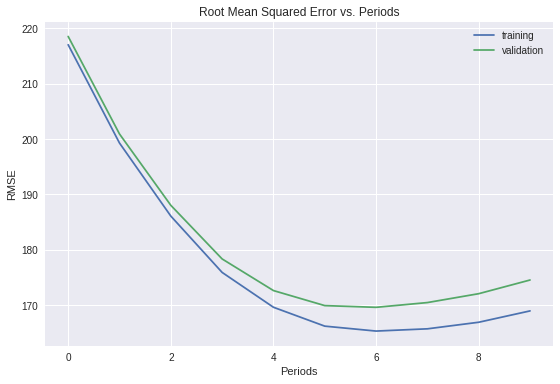

In [25]:
linear_regressor = train_model(
  learning_rate=0.00003,steps=500,batch_size=5,training_examples=training_examples,training_targets=training_targets,validation_example=validation_examples,validation_targets=validation_targets)